
### Загрузка dataset

In [ ]:
!gdown --id 1q_1fuNhjXpNFszcYu9QzWHo3kYwezQXU -O dataset.zip

!unzip dataset.zip -d /content/dataset/

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1q_1fuNhjXpNFszcYu9QzWHo3kYwezQXU
From (redirected): https://drive.google.com/uc?id=1q_1fuNhjXpNFszcYu9QzWHo3kYwezQXU&confirm=t&uuid=05960ade-7aa4-4955-81c3-25ef8ee427ae
To: /content/dataset.zip
100% 154M/154M [00:01<00:00, 113MB/s]
Archive:  dataset.zip
   creating: /content/dataset/dataset/
   creating: /content/dataset/dataset/masks/
  inflating: /content/dataset/dataset/masks/1803262049-00000501.png  
  inflating: /content/dataset/dataset/masks/1803280840-00000089.png  
  inflating: /content/dataset/dataset/masks/1803242348-00000392.png  
  inflating: /content/dataset/dataset/masks/1803251131-00000060.png  
  inflating: /content/dataset/dataset/masks/1803240928-00000328.png  
  inflating: /content/datas

### Подготовка данных

In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch
import glob
import os
import cv2

from torchvision import transforms
from torch.utils.data import Dataset
import torchvision.io as io

class SelfieDataset(Dataset):
    def __init__(self, imgs_list, mask_list):
        self.imgs = sorted(imgs_list)
        self.masks = sorted(mask_list)
        self.transform = transforms.Compose([
            lambda x: x / 255.0,
            lambda x: transforms.functional.crop(x, 0, 0, 768, 512)
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = io.read_image(self.imgs[idx])
        mask = io.read_image(self.masks[idx])

        img = self.transform(img)
        mask = self.transform(mask)

        return img, mask


In [ ]:
from torch import nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections



class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x


class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)


### Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику jaccard index. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для jaccard index, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний."""


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from tqdm.auto import tqdm
from torch import optim
import torchmetrics
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


def test(model, test_loader):
  model.eval()

  running_loss = 0.0
  jaccard_metric = 0.0
  with torch.no_grad():
      for images, masks in test_loader:
          outputs = model(images.cuda())
          running_loss += criterion(outputs, masks.cuda()).item()
          jaccard_metric += (jaccard(outputs.cpu(), masks.cpu() > jaccard.threshold)).item()

  return (running_loss / len(test_loader), jaccard_metric / len(test_loader))

def train(epochs, model, train_loader, test_loader, optimizer):
  trains_jaccard = []
  tests_jaccard = []
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    jaccard_metric = 0.0
    for images, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(images.cuda())

        loss = criterion(outputs, masks.cuda())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        jaccard_metric += (jaccard(outputs.cpu(), masks.cpu() > jaccard.threshold)).item()

    train_jaccard = (running_loss / len(train_loader), jaccard_metric / len(train_loader))
    test_jaccard = test(model, test_loader)
    trains_jaccard.append(train_jaccard)
    tests_jaccard.append(test_jaccard)
    print("Epoch:", epoch + 1, ", train: ", train_jaccard, ", test: ", test_jaccard)

  return trains_jaccard, tests_jaccard


Загрузка данных

In [ ]:
import glob
import os

path_to_masks = "/content/dataset/dataset/masks"
path_to_images = "/content/dataset/dataset/images"
image_files = glob.glob(os.path.join(path_to_images, "*.jpg"))
mask_files = glob.glob(os.path.join(path_to_masks, "*.png"))

train_portion = 0.95
train_dataset = SelfieDataset(
    image_files[:int(len(image_files) * train_portion)],
    mask_files[:int(len(image_files) * train_portion)]
)
test_dataset = SelfieDataset(
    image_files[int(len(image_files) * train_portion):],
    mask_files[int(len(image_files) * train_portion):]
)

jaccard = torchmetrics.JaccardIndex(task="binary")

net = UNET(3, 16, 1).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

Визуализация результатов

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

def show_result(jaccard, title):
    results = [
        {"Epoch": epoch_index + 1, "Metric type": "Loss", "Value": loss}
        for epoch_index, (loss, jaccard) in enumerate(jaccard)
    ] + [
        {"Epoch": epoch_index + 1, "Metric type": "Jaccard", "Value": jaccard}
        for epoch_index, (loss, jaccard) in enumerate(jaccard)
    ]

    df = pd.DataFrame(results)
    sns.lineplot(x="Epoch", y="Value", hue="Metric type", data=df).set(title=title)
    plt.show()

Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество

Epoch: 1 , train:  (0.8182694315910339, 0.08954452723264694) , test:  (0.6863932013511658, 0.0)
Epoch: 2 , train:  (0.7622202634811401, 0.12601350247859955) , test:  (0.6871058940887451, 0.0)
Epoch: 3 , train:  (0.7246696352958679, 0.19809743762016296) , test:  (0.6878365278244019, 0.0)
Epoch: 4 , train:  (0.6963814496994019, 0.2811654210090637) , test:  (0.6885735392570496, 0.0)
Epoch: 5 , train:  (0.6734652519226074, 0.3509366512298584) , test:  (0.6893619298934937, 0.0)
Epoch: 6 , train:  (0.6536774635314941, 0.42093971371650696) , test:  (0.6901712417602539, 0.0)
Epoch: 7 , train:  (0.6358373165130615, 0.4937177002429962) , test:  (0.6909679174423218, 0.5693582892417908)
Epoch: 8 , train:  (0.6191554069519043, 0.5533859133720398) , test:  (0.6917621493339539, 0.5695132613182068)
Epoch: 9 , train:  (0.6034063100814819, 0.5951991677284241) , test:  (0.6925846934318542, 0.538019597530365)
Epoch: 10 , train:  (0.5886718034744263, 0.6270283460617065) , test:  (0.6934611201286316, 0.4361

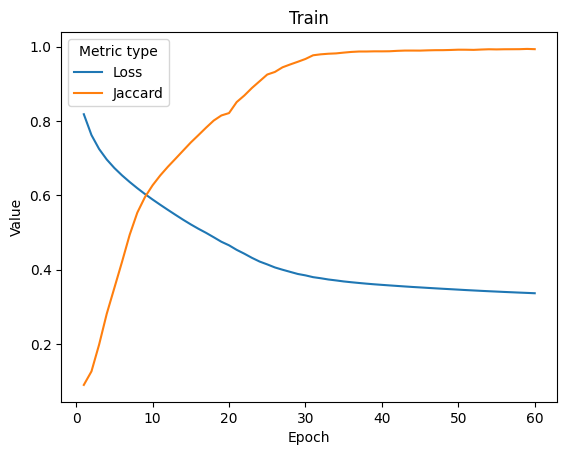

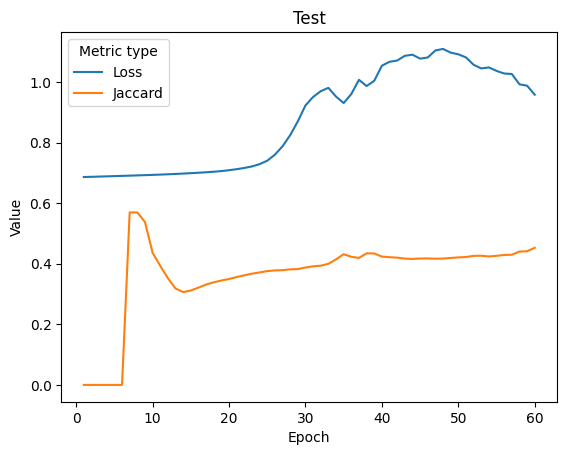

In [ ]:
batch_size = 4

train_loader = DataLoader(
    Subset(train_dataset, range(batch_size)),
    batch_size=batch_size,
)
test_loader = DataLoader(
    Subset(test_dataset, range(batch_size)),
    batch_size=batch_size,
)

train_jaccard, test_jaccard = train(
    60, net, train_loader, test_loader, optimizer
)

show_result(train_jaccard, "Train")
show_result(test_jaccard, "Test")


Обучить на всем train, построить train/val кривые для loss и для jaccard index

Epoch: 1 , train:  (0.5719706318880382, 0.5680386668757389) , test:  (0.5129295945167541, 0.6456261277198792)
Epoch: 2 , train:  (0.4773070464008733, 0.6625363130318491) , test:  (0.46405026912689207, 0.6647721767425537)
Epoch: 3 , train:  (0.4496131944028955, 0.6815136357357627) , test:  (0.45690188407897947, 0.6695479393005371)
Epoch: 4 , train:  (0.43618708880324114, 0.6890436116017793) , test:  (0.4452426493167877, 0.6741914987564087)
Epoch: 5 , train:  (0.4282755660383325, 0.6910133731992621) , test:  (0.4447169840335846, 0.6847623944282532)
Epoch: 6 , train:  (0.42119284962352954, 0.6937424396213733) , test:  (0.43811153173446654, 0.6857662558555603)
Epoch: 7 , train:  (0.414587979881387, 0.6990242926697982) , test:  (0.43323923349380494, 0.6818674087524415)
Epoch: 8 , train:  (0.41029618696162573, 0.7019634485244751) , test:  (0.42925097346305846, 0.6875306248664856)
Epoch: 9 , train:  (0.4064027805077402, 0.7039118007609718) , test:  (0.4276042640209198, 0.6955300092697143)
Epo

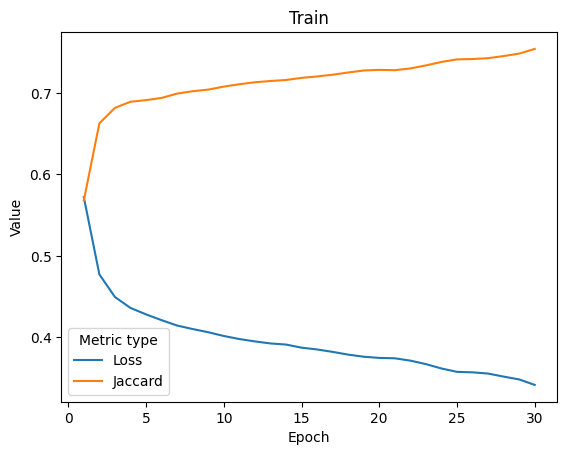

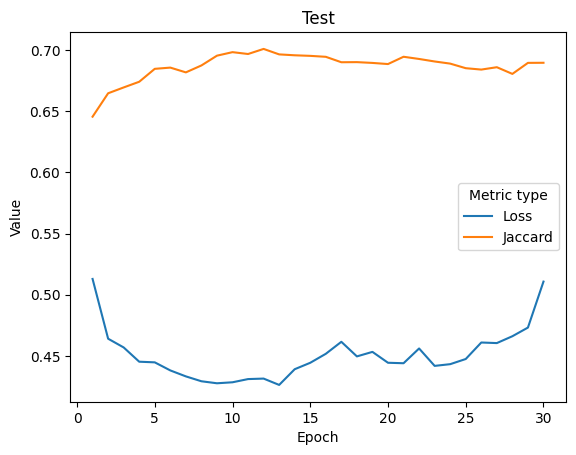

In [ ]:
batch_size = 20

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)


train_jaccard, test_jaccard = train(
    30, net, train_loader, test_loader, optimizer
)

show_result(train_jaccard, "Train")
show_result(test_jaccard, "Test")

Визуализировать topN самых плохих предсказаний.

100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


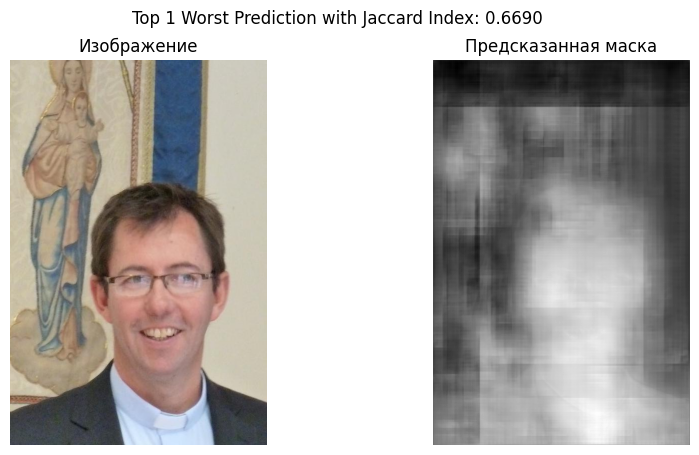

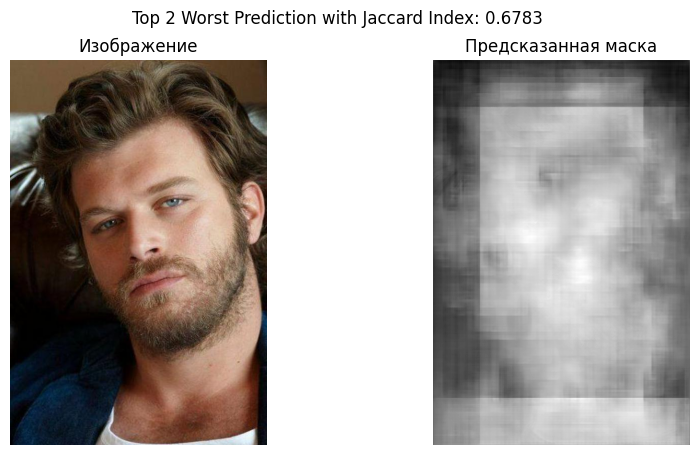

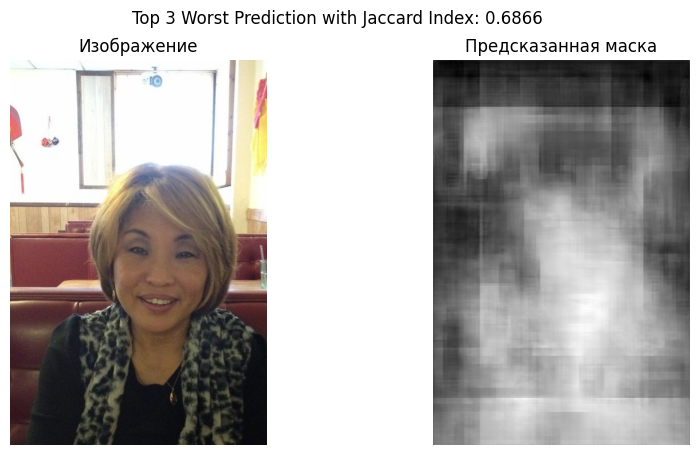

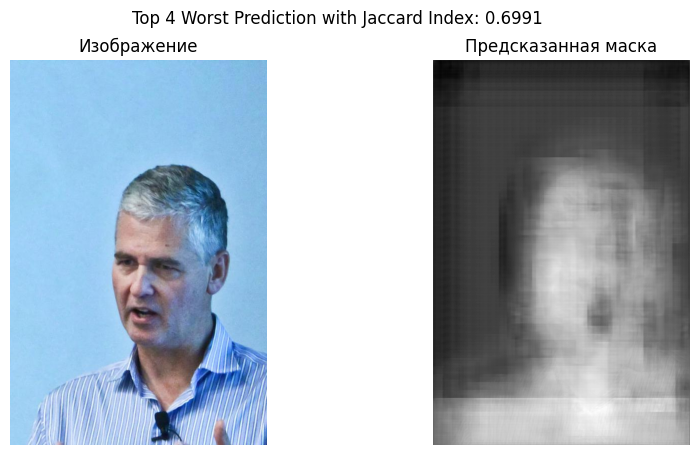

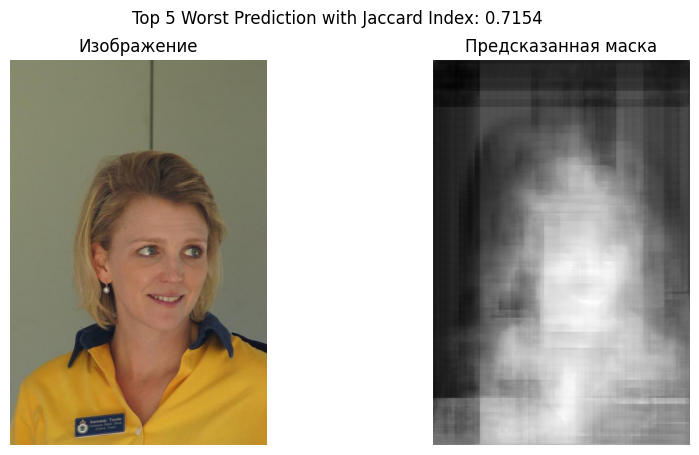

In [ ]:
import functools
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt


def worst_test_cases(n):
    results = []
    net.eval()
    with torch.no_grad():
        for images, masks in tqdm(test_loader):
            images = images.cuda()
            masks = masks.cuda()
            outputs = net(images)
            jaccard_metric = (jaccard(outputs.detach().cpu(), masks.detach().cpu() > jaccard.threshold)).item()
            results.append((outputs[0].detach().cpu(), jaccard_metric, images[0].detach().cpu()))

    return sorted(results, key=lambda x: x[1])[:n]

def show_worst_predictions(n):
    worst = worst_test_cases(n)

    for i in range(n):
        pred_mask, jaccard_metric, image = worst[i]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0).numpy())
        plt.title('Изображение')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title('Предсказанная маска')
        plt.axis('off')

        plt.suptitle(f'Top {i+1} Worst Prediction with Jaccard Index: {jaccard_metric:.4f}')
        plt.show()

show_worst_predictions(5)

### Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.


На этом моменте закончились ресурсы на сolab :(

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader
from torch import optim
import copy

batch_size = 20

augmentations = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.Resize((768, 512)),])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = augmentations

train_dataset_extended = ConcatDataset(
    [train_dataset, train_dataset_augmented]
)

train_loader_extended = DataLoader(train_dataset_extended, batch_size=batch_size, shuffle=True)

In [ ]:
level = 5
net = UNET(3, 16, 1, level).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters())
train_jaccard, test_jacdard = train(
    10, net, train_loader_extended, test_loader, optimizer
)
show_result(results[2], "5 level")


### Попробовать улучшить качество изменяя архитектуру.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=4, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down),
                               first_out_channels * (2 ** (n_down - 1)),
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)


In [ ]:
batch_size = 20

net = UNET(3, 16, 1).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)


train_jaccard, test_jaccard = train(
    30, net, train_loader, test_loader, optimizer
)

show_result(train_jaccard, "Train")
show_result(test_jaccard, "Test")